In [477]:
import sys
import os
import math
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torcheval.metrics import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix

In [478]:
# Append the path for module imports
sys.path.append('../')

# Import custom modules
from modules.dataloader import load_npy_files
from modules.linear_transformation import LinearTransformations
from modules.classifier import DenseLayer, BCELoss, CustomLoss, BCEWithLogits, FocalLoss

In [479]:
device = torch.device("cpu")

In [480]:
# Define possible configurations for audio feature directories
audio_feature_paths = {
    'logmel': 'D:\Projects\Thesis\Audio',
    'mfcc': 'D:\Projects\Thesis\Audio 2\mfcc_extracted'
}

# Function to get the audio feature path based on the selected configuration
def get_audio_feature_path(config_name):
    if config_name in audio_feature_paths:
        return audio_feature_paths[config_name]
    else:
        raise ValueError(f"Configuration '{config_name}' not found. Available options: logmel, mfcc.")


In [481]:
### Device configuration
device = torch.device("cpu")
print(f"Device: {device}")

### Audio Feature selection: 'logmel' or 'mfcc'
selected_config = 'logmel'
audio_features_dir = get_audio_feature_path(selected_config)

#### Data Configuration: 8 16 32 64 128
train_batch_size = 32   # Set the batch size for training data
val_batch_size = 16     # Set the batch size for validation data
test_batch_size= 16     # Set the batch size for testing data

#FIXED CONSTANT
max_pad = 197

### Hyperparameters
threshold = 0.5              # for predictions
learning_rate = 1e-5         # For optimizer
cl_dropout_rate = 0.4        # for FinalClassifier
att_dropout_rate = 0.3       # for MutualCrossAttention
num_epochs = 5              # for model training

### Classifier Configuration
isBCELoss = True                          # !!! SET ACCORDINGLY !!!
criterion = BCELoss()
# criterion = BCEWithLogits()
# criterion = CustomLoss(pos_weight=2.94)
# criterion = FocalLoss(alpha=0.25, gamma=2, pos_weight=0.34)

# !!! Choose Classifier !!! False = Dense Layer, True = Final Classifier
isFinalClassifier = True

# ### For cross validation
# num_folds = 5           # Set the number of folds for cross-validation
# batch_size = 32         # Set the batch size for cross-validation


Device: cpu


In [482]:
class FinalClassifier(nn.Module):
    def __init__(self, input_size, dropout_rate=0.5):
        super(FinalClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)  # From 2304 to 2048
        self.fc2 = nn.Linear(1024, 512)        # From 2048 to 1024
        # self.fc3 = nn.Linear(1024, 512)         # Optional 512 or 768

        self.dropout = nn.Dropout(dropout_rate)
        self.dense = nn.Linear(512, 1)          # Final output layer
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        # x = self.fc3(x)
        # x = self.relu(x)

        x = self.dense(x)
        if isBCELoss:
            x = self.sigmoid(x)
        return x


### Data Loading

In [483]:
class MultimodalDataset(Dataset):
    def __init__(self, id_label_df, text_features, audio_features, video_features):
        self.id_label_df = id_label_df
        
        # Convert feature lists to dictionaries for fast lookup
        self.text_features = {os.path.basename(file).split('.')[0]: tensor for file, tensor in text_features}
        self.audio_features = {os.path.basename(file).split('_')[1].split('.')[0]: tensor for file, tensor in audio_features}
        self.video_features = {os.path.basename(file).split('_')[0]: tensor for file, tensor in video_features}

        # List to store missing files
        self.missing_files = []

        # Filter out entries with missing files
        self.valid_files = self._filter_valid_files()

    def _filter_valid_files(self):
        valid_indices = []
        missing_files = []

        for idx in range(len(self.id_label_df)):
            imdbid = self.id_label_df.iloc[idx]['IMDBid']

            # Check if the IMDBid exists in each modality's features
            if imdbid in self.text_features and imdbid in self.audio_features and imdbid in self.video_features:
                valid_indices.append(idx)
            else:
                missing_files.append({'IMDBid': imdbid})

        # Filter id_label_df to only include valid rows
        self.id_label_df = self.id_label_df.iloc[valid_indices].reset_index(drop=True)
        self.missing_files = missing_files
        
        # Update valid_indices to reflect the new indices after resetting
        valid_indices = list(range(len(self.id_label_df)))

        # Return valid indices
        return valid_indices

    def __len__(self):
        return len(self.valid_files)

    def __getitem__(self, idx):
        # Get the original index from the filtered valid files
        original_idx = self.valid_files[idx]
        imdbid = self.id_label_df.iloc[original_idx]['IMDBid']
        label = self.id_label_df.iloc[original_idx]['Label']

        # Retrieve data from the loaded features
        text_data = self.text_features.get(imdbid, torch.zeros((1024,)))
        audio_data = self.audio_features.get(imdbid, torch.zeros((1, 197, 768)))
        video_data = self.video_features.get(imdbid, torch.zeros((95, 768)))
        
        # Define label mapping
        label_map = {'red': 1, 'green': 0} 
        
        # Convert labels to tensor using label_map
        try:
            label_data = torch.tensor([label_map[label]], dtype=torch.float32)
        except KeyError as e:
            print(f"Error: Label '{e}' not found in label_map.")
            raise

        return imdbid, text_data, audio_data, video_data, label_data


In [484]:
def collate_fn(batch):
    imdbids, text_data, audio_data, video_data, label_data = zip(*batch)

    # Convert lists to tensors
    text_data = torch.stack(text_data)
    audio_data = torch.stack(audio_data)

    # Pad video data
    max_length = max(v.size(0) for v in video_data)
    video_data_padded = torch.stack([
        F.pad(v, (0, 0, 0, max_length - v.size(0)), "constant", 0)
        for v in video_data
    ])

    label_data = torch.stack(label_data)

    return imdbids, text_data, audio_data, video_data_padded, label_data

In [485]:
def filter_video_features(video_features, lower_bound=35, upper_bound=197):
    # Assuming video_features is a list of tuples where the second element is the numpy array
    filtered_video_features = [v for v in video_features if lower_bound <= v[1].shape[0] <= upper_bound]
    return filtered_video_features


In [486]:
# Load the labels DataFrame
id_label_df = pd.read_excel('../misc/MM-Trailer_dataset.xlsx')

# Define the directories
text_features_dir = 'D:\Projects\Thesis\Text'
audio_features_dir = audio_features_dir
video_features_dir = 'D:\Projects\Thesis\Video'

# Load the feature vectors from each directory
text_features = load_npy_files(text_features_dir)
audio_features = load_npy_files(audio_features_dir)
video_features = load_npy_files(video_features_dir)

video_features = filter_video_features(video_features)

print(f"Number of text feature vectors loaded: {len(text_features)}")
print(f"Number of audio feature vectors loaded: {len(audio_features)}")
print(f"Number of video feature vectors loaded: {len(video_features)}")

# Drop unnecessary columns
id_label_df = id_label_df.drop(columns=['Movie Title', 'URL'])

full_dataset = MultimodalDataset(id_label_df, text_features, audio_features, video_features)

# perform train-test split on the filtered DataFrame
train_df, val_test_df = train_test_split(
    full_dataset.id_label_df, test_size=0.3, random_state=42, stratify=full_dataset.id_label_df['Label'])

# Further splitting remaining set into validation and test sets
val_df, test_df = train_test_split(
    val_test_df, test_size=0.5, random_state=42, stratify=val_test_df['Label'])

print("train_df shape:", train_df.shape)
print("val_df shape:", val_df.shape)
print("test_df shape:", test_df.shape)

print("Train label distribution:", train_df['Label'].value_counts())
print("Validation label distribution:", val_df['Label'].value_counts())
print("Test label distribution:", test_df['Label'].value_counts())

print("-" * 40)

# create datasets based on these splits
train_dataset = MultimodalDataset(train_df, text_features, audio_features, video_features)
val_dataset = MultimodalDataset(val_df, text_features, audio_features, video_features)
test_dataset = MultimodalDataset(test_df, text_features, audio_features, video_features)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, collate_fn=collate_fn, generator=torch.Generator().manual_seed(42))
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=0, collate_fn=collate_fn, generator=torch.Generator().manual_seed(42))
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, collate_fn=collate_fn, generator=torch.Generator().manual_seed(42))

# Function to calculate and print the size of each DataLoader
def print_dataloader_sizes(dataloader, name):
    total_samples = len(dataloader.dataset)  # Get the size of the dataset
    num_batches = len(dataloader)  # Get the number of batches
    print(f"{name} DataLoader: Total Samples = {total_samples}, Number of Batches = {num_batches}")

# Print sizes of each DataLoader
print_dataloader_sizes(train_dataloader, "Train")
print_dataloader_sizes(val_dataloader, "Validation")
print_dataloader_sizes(test_dataloader, "Test")

Number of text feature vectors loaded: 1353
Number of audio feature vectors loaded: 1353
Number of video feature vectors loaded: 1325
train_df shape: (927, 2)
val_df shape: (199, 2)
test_df shape: (199, 2)
Train label distribution: Label
green    693
red      234
Name: count, dtype: int64
Validation label distribution: Label
green    149
red       50
Name: count, dtype: int64
Test label distribution: Label
green    149
red       50
Name: count, dtype: int64
----------------------------------------
Train DataLoader: Total Samples = 927, Number of Batches = 29
Validation DataLoader: Total Samples = 199, Number of Batches = 13
Test DataLoader: Total Samples = 199, Number of Batches = 13


In [487]:
def pad_features(features, max_pad=197):
    # Pad or trim the sequence dimension to `max_pad`
    if features.size(1) < max_pad:
        # Pad to the right along the sequence dimension
        features = F.pad(features, (0, 0, 0, max_pad - features.size(1)))
    else:
        # Trim if the sequence is longer than `max_pad`
        features = features[:, :max_pad, :]
    return features

In [488]:
class MutualCrossAttention(nn.Module):
    def __init__(self, dropout):
        super(MutualCrossAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(768)
        self.device = torch.device("cpu")

    def forward(self, x1, x2):
        # Move x1 and x2 to the correct device
        x1, x2 = x1.to(self.device), x2.to(self.device)

        # Ensure inputs are 3D
        if x1.dim() == 2:
            x1 = x1.unsqueeze(0)
        if x2.dim() == 2:
            x2 = x2.unsqueeze(0)

        # Assign x1 and x2 to query and key
        query = x1
        key = x2
        d = query.shape[-1]

        # Basic attention mechanism formula to get intermediate output A
        scores = torch.bmm(query, key.transpose(1, 2)) / math.sqrt(d)
        output_A = torch.bmm(self.dropout(F.softmax(scores, dim=-1)), x2)

        # Make the summation of the two intermediate outputs
        output = output_A
        
        return output

In [489]:
def HadamardProduct(tensor1, tensor2):
    # Ensure both tensors have the same shape
    if tensor1.shape != tensor2.shape:
        raise ValueError("Tensors must have the same shape for Hadamard product.")
    
    # Compute the Hadamard product
    return tensor1 * tensor2

In [490]:
# class EmbracementLayer(nn.Module):
#     def __init__(self, d_in, d_out):
#         super(EmbracementLayer, self).__init__()
#         self.fc = nn.Linear(d_in, d_out)
#         self.norm = nn.LayerNorm(d_out)
#         self.activation = nn.ReLU()

#     def forward(self, video_features, audio_features, text_features):
#         # Ensure all inputs are on the same device as the layer
#         device = next(self.parameters()).device
#         video_features = video_features.to(device)
#         audio_features = audio_features.to(device)
#         text_features = text_features.to(device)

#         # # Print shapes for debugging
#         # print("Video features shape:", video_features.shape)
#         # print("Audio features shape:", audio_features.shape)
#         # print("Text features shape:", text_features.shape)

#         # Adjust dimensions if necessary
#         if video_features.dim() == 1:
#             video_features = video_features.unsqueeze(0)
#         if audio_features.dim() == 1:
#             audio_features = audio_features.unsqueeze(0)
#         if text_features.dim() == 1:
#             text_features = text_features.unsqueeze(0)

#         # Ensure all features have the same sequence length
#         if video_features.shape[0] != audio_features.shape[0] or video_features.shape[0] != text_features.shape[0]:
#             # Use the maximum sequence length
#             max_seq_len = max(video_features.shape[0], audio_features.shape[0], text_features.shape[0])
            
#             # Expand tensors to match the maximum sequence length
#             video_features = video_features.expand(max_seq_len, -1)
#             audio_features = audio_features.expand(max_seq_len, -1)
#             text_features = text_features.expand(max_seq_len, -1)

#         # Concatenate features along the last dimension
#         combined_features = torch.cat([video_features, audio_features, text_features], dim=1)
        
#         # Apply linear transformation
#         transformed_features = self.fc(combined_features)
        
#         # Apply normalization and activation
#         norm_features = self.norm(transformed_features)
#         output = self.activation(norm_features)
        
#         return output

In [491]:
# Element Add

class EmbracementLayer(nn.Module):
    def __init__(self, d_in=768, d_out=768):
        super(EmbracementLayer, self).__init__()
        self.fc = nn.Linear(d_in, d_out)
        self.norm = nn.LayerNorm(d_out)
        self.activation = nn.ReLU()
    def forward(self, video_features, audio_features, text_features):
        combined_features = video_features + audio_features + text_features

        transformed_features = self.fc(combined_features)
        norm_features = self.norm(transformed_features)
        output = self.activation(norm_features)

        return output

In [492]:
def get_optimizer(parameters, lr=learning_rate):
    # Create an optimizer, for example, Adam
    return optim.Adam(parameters, lr=lr)

In [493]:
def PairCrossAttention(modalityAlpha, modalityBeta, dropout=att_dropout_rate):
    mutual_cross_attn = MutualCrossAttention(dropout)

    modalityAlpha = modalityAlpha.requires_grad_(True)
    modalityBeta = modalityBeta.requires_grad_(True)
    
    return mutual_cross_attn(modalityAlpha, modalityBeta)

In [494]:
def train_model(dense_layer, dataloader, criterion, optimizer, device, output_dir='results/', output_filename='train_predictions.csv'):
    dense_layer.train()
    total_loss = 0.0

    os.makedirs(output_dir, exist_ok=True)

    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    accuracy_metric = BinaryAccuracy().to(device)

    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()
    accuracy_metric.reset()

    print("-" * 20, "Train", "-" * 20)

    for batch in dataloader:
        imdbids, text_data, audio_data, video_data, targets = batch
        batch_size = text_data.size(0)
        
        # Move all tensors to device
        text_data = text_data.to(device).requires_grad_(True)
        audio_data = audio_data.to(device).requires_grad_(True)
        video_data = video_data.to(device).requires_grad_(True)
        targets = targets.to(device)
        
        fused_features_list = []
            
            # Process each item in the batch
        for i in range(batch_size):

                print("Before transformation and padding:")
                print("Text feature shape:", text_data[i].shape)  # [1024]
                print("Audio feature shape:", audio_data[i].shape)  # [1, 197, 768]
                print("Video feature shape:", video_data[i].shape)  # [95, 768]

                # Transform text features
                linear_transform_text = LinearTransformations(text_data[i].shape[-1], 768).to(device)
                text_feature = linear_transform_text(text_data[i].unsqueeze(0))  # [1, 768]

                # Transform audio features - remove extra dimension and take last token
                audio_feature = audio_data[i].squeeze(0)  # Remove batch dim -> [197, 768]
                audio_feature = audio_feature[-1:, :]  # Take last token -> [1, 768]

                # Transform and pad video features
                video_feature = video_data[i]  # [174, 768]
                video_feature = pad_features(video_feature.unsqueeze(0))  # Add batch dim and pad to [1, 197, 768]
                
                print("After transformation and padding:")
                print("Text feature shape:", text_feature.shape)  # [1, 768]
                print("Audio feature shape:", audio_feature.shape)  # [1, 768]
                print("Video feature shape:", video_feature.shape)  # [1, 197, 768]

                # Cross attention between modalities
                text_video = PairCrossAttention(text_feature, video_feature.squeeze(0))  # video: [197, 768]
                text_audio = PairCrossAttention(text_feature, audio_feature)
                audio_video = PairCrossAttention(audio_feature, video_feature.squeeze(0))
                audio_text = PairCrossAttention(audio_feature, text_feature)
                video_text = PairCrossAttention(video_feature.squeeze(0), text_feature)
                video_audio = PairCrossAttention(video_feature.squeeze(0), audio_feature)

                # Hadamard products
                text_combined = HadamardProduct(text_video, text_audio)
                audio_combined = HadamardProduct(audio_video, audio_text)
                video_combined = HadamardProduct(video_text, video_audio)

                # Calculate input dimension for embracement layer
                d_in = video_combined.shape[-1] + audio_combined.shape[-1] + text_combined.shape[-1]
                embracement_layer = EmbracementLayer(d_in, d_in).to(device)

                video_last = video_combined[:,-1,:]

                # Get final fused features
                fused_features = embracement_layer(
                    video_last, 
                    audio_combined.squeeze(), 
                    text_combined.squeeze()
                )
                
                # # Make sure fused_features has the right shape
                # if len(fused_features.shape) == 1:
                #     fused_features = fused_features.unsqueeze(0)  # Average across sequence dimension if present
                
                fused_features_list.append(fused_features)

                print("Fused features shape:", fused_features.shape)

        # Stack all fused features for the batch
        batch_fused_features = torch.stack(fused_features_list) # [batch_size, feature_dim]

        batch_fused_features = batch_fused_features.mean(dim=1)

        print("Final fused features shape:", batch_fused_features.shape)

        # Forward pass through dense layer
        predictions = dense_layer(batch_fused_features)  # [batch_size, 1]
        predictions = predictions.squeeze()  # Remove last dimension
        targets = targets.squeeze().float()

        print("Predictions shape:", predictions.shape)
        print("Targets shape:", targets.shape)
        
        # Compute loss
        loss = criterion(predictions, targets)
        total_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if not isBCELoss:
            predictions = torch.sigmoid(predictions)
        
        preds = (predictions >= threshold).float()

        precision_metric.update(preds.long(), targets.long())
        recall_metric.update(preds.long(), targets.long())
        f1_metric.update(preds.long(), targets.long())
        accuracy_metric.update(preds.long(), targets.long())

    # Compute metrics
    train_precision = precision_metric.compute().item()
    train_recall = recall_metric.compute().item()
    train_f1_score = f1_metric.compute().item()
    train_accuracy = accuracy_metric.compute().item()
    train_average_loss = total_loss / len(dataloader)

    print(f"\nFinal Metrics:")
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Train Precision: {train_precision:.4f}")
    print(f"Train Recall: {train_recall:.4f}")
    print(f"Train F1 Score: {train_f1_score:.4f}")
    print(f"Train Loss: {train_average_loss:.4f}")

    return train_average_loss, train_accuracy, train_precision, train_recall, train_f1_score

In [495]:
def evaluate_model(dense_layer, dataloader, criterion, device, output_dir='results/', output_filename='val_predictions.csv'):
    dense_layer.eval()
    total_loss = 0

    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    accuracy_metric = BinaryAccuracy().to(device)

    all_predictions = []
    all_targets = []
    
    print("-" * 20, "Eval", "-" * 20)

    with torch.no_grad():
        for batch in dataloader:
            imdbids, text_data, audio_data, video_data, targets = batch

            batch_size = text_data.size(0)
            
            # Move all tensors to device
            text_data = text_data.to(device)
            audio_data = audio_data.to(device)
            video_data = video_data.to(device)
            targets = targets.to(device)

            fused_features_list = []

            for i in range(batch_size):
                linear_transform_text = LinearTransformations(text_data[i].shape[-1], 768)
                text_feature = linear_transform_text(text_data[i].unsqueeze(0))     

                audio_feature = audio_data[i].squeeze(0)
                audio_feature = audio_feature[-1:, :]

                video_feature = video_data[i]
                video_feature = pad_features(video_feature.unsqueeze(0))

                text_video = PairCrossAttention(text_feature, video_feature.squeeze(0))
                text_audio = PairCrossAttention(text_feature, audio_feature)
                audio_video = PairCrossAttention(audio_feature, video_feature.squeeze(0))
                audio_text = PairCrossAttention(audio_feature, text_feature)
                video_text = PairCrossAttention(video_feature.squeeze(0), text_feature)
                video_audio = PairCrossAttention(video_feature.squeeze(0), audio_feature)

                text_combined = HadamardProduct(text_video, text_audio)
                audio_combined = HadamardProduct(audio_video, audio_text)
                video_combined = HadamardProduct(video_text, video_audio)

                d_in = video_combined.shape[-1] + audio_combined.shape[-1] + text_combined.shape[-1]
                embracement_layer = EmbracementLayer(d_in, d_in).to(device)

                # Get final fused features
                fused_features = embracement_layer(
                    video_combined[-1], 
                    audio_combined[-1], 
                    text_combined[-1]
                )
                

                fused_features_list.append(fused_features)

            batch_fused_features = torch.stack(fused_features_list) # [batch_size, feature_dim]
            batch_fused_features = batch_fused_features.mean(dim=1)

            print("Final fused features shape:", batch_fused_features.shape)

            predictions = dense_layer(batch_fused_features)
            predictions = predictions.squeeze()
            targets = targets.squeeze().float()

            loss = criterion(predictions, targets)
            total_loss += loss.item()

            if not isBCELoss:
                predictions = torch.sigmoid(predictions)

            preds = (predictions >= threshold).float()

            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(predictions.cpu().numpy())

            precision_metric.update(preds.long(), targets.long())
            recall_metric.update(preds.long(), targets.long())
            f1_metric.update(preds.long(), targets.long())
            accuracy_metric.update(preds.long(), targets.long())
        
        # Compute metrics
        val_precision = precision_metric.compute().item()
        val_recall = recall_metric.compute().item()
        val_f1_score = f1_metric.compute().item()
        val_accuracy = accuracy_metric.compute().item()


        # val_conf_matrix = confusion_matrix(all_targets, np.round(all_predictions))
        val_average_loss = total_loss / len(dataloader)

        print(f"\nFinal Metrics:")
        print(f"Val Accuracy: {val_accuracy:.4f}")
        print(f"Val Precision: {val_precision:.4f}")
        print(f"Val Recall: {val_recall:.4f}")
        print(f"Val F1 Score: {val_f1_score:.4f}")
        print(f"Val Loss: {val_average_loss:.4f}")

        return val_average_loss, val_accuracy, val_precision, val_recall, val_f1_score

In [496]:
def test_model(dense_layer, dataloader, criterion, device, output_dir='results/', output_filename='test_predictions.csv'):
    dense_layer.eval()
    total_loss = 0.0

    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    accuracy_metric = BinaryAccuracy().to(device)

    all_predictions = []
    all_targets = []

    print("-" * 20, "Test", "-" * 20)

    with torch.no_grad():
        for batch in dataloader:
            imdbids, text_data, audio_data, video_data, targets = batch
            batch_size = text_data.size(0)

            # Move all tensors to device
            text_data = text_data.to(device)
            audio_data = audio_data.to(device)
            video_data = video_data.to(device)
            targets = targets.to(device)

            fused_features_list = []

            for i in range(batch_size):
                # Transform text
                linear_transform_text = LinearTransformations(text_data[i].shape[-1], 768)
                text_feature = linear_transform_text(text_data[i].unsqueeze(0))

                # Transform audio
                audio_feature = audio_data[i].squeeze(0)
                audio_feature = audio_feature[-1:, :]

                # Transform and pad video
                video_feature = video_data[i]
                video_feature = pad_features(video_feature.unsqueeze(0))

                # Cross attention between modalities
                text_video = PairCrossAttention(text_feature, video_feature.squeeze(0))
                text_audio = PairCrossAttention(text_feature, audio_feature)
                audio_video = PairCrossAttention(audio_feature, video_feature.squeeze(0))
                audio_text = PairCrossAttention(audio_feature, text_feature)
                video_text = PairCrossAttention(video_feature.squeeze(0), text_feature)
                video_audio = PairCrossAttention(video_feature.squeeze(0), audio_feature)

                # Hadamard products
                text_combined = HadamardProduct(text_video, text_audio)
                audio_combined = HadamardProduct(audio_video, audio_text)
                video_combined = HadamardProduct(video_text, video_audio)

                # Calculate input dimension for embracement layer
                d_in = video_combined.shape[-1] + audio_combined.shape[-1] + text_combined.shape[-1]
                embracement_layer = EmbracementLayer(d_in, d_in).to(device)

                # Get final fused features
                fused_features = embracement_layer(
                    video_combined[-1], 
                    audio_combined[-1], 
                    text_combined[-1]
                )
                

                fused_features_list.append(fused_features)

        # process batch
        batch_fused_features = torch.stack(fused_features_list) # [batch_size, feature_dim]
        batch_fused_features = batch_fused_features.mean(dim=1)

        print("Final fused features shape:", batch_fused_features.shape)

        # Forward pass through dense layer
        predictions = dense_layer(batch_fused_features)
        predictions = predictions.squeeze()
        targets = targets.squeeze().float()

        # Compute loss
        loss = criterion(predictions, targets)
        total_loss += loss.item()

        if not isBCELoss:
            predictions = torch.sigmoid(predictions)
        
        preds = (predictions >= threshold).float()

        all_predictions.extend(predictions.cpu().numpy())
        all_targets.extend(predictions.cpu().numpy())

        precision_metric.update(preds.long(), targets.long())
        recall_metric.update(preds.long(), targets.long())
        f1_metric.update(preds.long(), targets.long())
        accuracy_metric.update(preds.long(), targets.long())

    test_precision = precision_metric.compute().item()
    test_recall = recall_metric.compute().item()
    test_f1_score = f1_metric.compute().item()
    test_accuracy = accuracy_metric.compute().item()

    # test_conf_matrix = confusion_matrix(all_targets, np.round(all_predictions))
    test_average_loss = total_loss / len(dataloader)

    print(f"\nFinal Metrics:")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1 Score: {test_f1_score:.4f}")
    print(f"Test Loss: {test_average_loss:.4f}")

    return test_average_loss, test_accuracy, test_precision, test_recall, test_f1_score


### Fusion

In [499]:
# Initialize list to store fused features for each file
fused_features_list = []
labels_list = []
batch_size = 64  # Adjust based on your available memory

for batch_start in range(0, len(text_features), batch_size):
    batch_end = min(batch_start + batch_size, len(text_features))
    batch_text_features = text_features[batch_start:batch_end]
    batch_audio_features = audio_features[batch_start:batch_end]
    batch_video_features = video_features[batch_start:batch_end]
    print(f"Batch: {batch_start}")
    # Loop through all the files in the dataset
    for i in range(len(batch_text_features)):
        # Extract features for the current file
        text_file_name, text_feature = text_features[i]  # Renamed to avoid shadowing
        audio_file_name, audio_feature = audio_features[i]  # Renamed to avoid shadowing
        video_file_name, video_feature = video_features[i]  # Renamed to avoid shadowing

        # print(f"Processing file {text_file_name}")

        # Check if any features are missing
        if text_feature is None or audio_feature is None or video_feature is None:
            print(f"Skipping file {i + 1}/{len(text_features)}: Missing features for {text_file_name}, {audio_file_name}, {video_file_name}")
            continue  # Skip to the next iteration

        # print("Text file name:", text_file_name)
        # print("Audio file name:", audio_file_name)
        # print("Video file name:", video_file_name)

        print("Text features shape:", text_feature.shape)
        print("Audio features shape:", audio_feature.shape)
        print("Video features shape:", video_feature.shape)

        # Transform text features
        linear_transform_text = LinearTransformations(text_feature.shape[-1], 768)
        text_feature = linear_transform_text(text_feature.unsqueeze(0))  # [1, 768]

        # Transform audio features (use last sequence)
        audio_feature = audio_feature[:, -1, :]  # Shape: [1, 768]

        # Pad video features
        video_feature = video_feature.unsqueeze(0)  # [1, 197, 768]
        video_feature = pad_features(video_feature)
        video_feature = video_feature.squeeze(0)  # [1, 197, 768]
        
        print("After transformation:")
        print("text_features shape:", text_feature.shape)
        print("audio_features shape:", audio_feature.shape)
        print("video_features shape:", video_feature.shape, '\n')

        with torch.no_grad():
            
            text_video = PairCrossAttention(text_feature, video_feature)
            text_audio = PairCrossAttention(text_feature, audio_feature)
            audio_video = PairCrossAttention(audio_feature, video_feature)
            audio_text = PairCrossAttention(audio_feature, text_feature)
            video_text = PairCrossAttention(video_feature, text_feature)
            video_audio = PairCrossAttention(video_feature, audio_feature)

            text_combined = HadamardProduct(text_video, text_audio)
            audio_combined = HadamardProduct(audio_video, text_audio)
            video_combined = HadamardProduct(video_text, video_audio)

            print("Text-Video Shape:", text_video.shape)
            print("Text-Audio Shape:", text_audio.shape)
            print("Audio-Video Shape:", audio_video.shape)
            print("Audio-Text Shape:", audio_text.shape)
            print("Video-Text Shape:", video_text.shape)
            print("Video-Audio Shape:", video_audio.shape, '\n')

            print("Text-Combined Shape:", text_combined.shape)
            print("Audio-Combined Shape:", audio_combined.shape)
            print("Video-Combined Shape:", video_combined.shape, '\n')

            # Calculate d_in
            d_in = video_combined.shape[-1] + audio_combined.shape[-1] + text_combined.shape[-1]
            embracement_layer = EmbracementLayer(768, 768).to(device)

            video_combined = video_combined.to(device)
            audio_combined = audio_combined.to(device)
            text_combined = text_combined.to(device)

            video_last = video_combined

            # Process features
            fused_features = embracement_layer(video_combined[-1], audio_combined[-1], text_combined[-1])            
            print('\n',"Fused Features Shape:", fused_features.shape, '\n')

            print("TV and AV: ", text_video.shape, audio_video.shape, '\n')

            print("TA: ", text_audio.shape, '\n')

            # Append the fused features and the corresponding label to the lists
            fused_features_list.append(fused_features)
            label = id_label_df.iloc[i]['Label']  # Assuming you have a column 'Label'
            labels_list.append(label)

        del text_feature, audio_feature, video_feature
        del text_video, text_audio, audio_video
        
# Stack all fused features into a tensor for training
fused_features_tensor = torch.stack(fused_features_list)

# Convert labels to tensor
label_map = {'red': 1, 'green': 0}  # Adjust if your labels differ
labels_tensor = torch.tensor([label_map[label] for label in labels_list], dtype=torch.float32)

Batch: 0
Text features shape: torch.Size([1024])
Audio features shape: torch.Size([1, 197, 768])
Video features shape: torch.Size([95, 768])
After transformation:
text_features shape: torch.Size([1, 768])
audio_features shape: torch.Size([1, 768])
video_features shape: torch.Size([197, 768]) 

Text-Video Shape: torch.Size([1, 1, 768])
Text-Audio Shape: torch.Size([1, 1, 768])
Audio-Video Shape: torch.Size([1, 1, 768])
Audio-Text Shape: torch.Size([1, 1, 768])
Video-Text Shape: torch.Size([1, 197, 768])
Video-Audio Shape: torch.Size([1, 197, 768]) 

Text-Combined Shape: torch.Size([1, 1, 768])
Audio-Combined Shape: torch.Size([1, 1, 768])
Video-Combined Shape: torch.Size([1, 197, 768]) 


 Fused Features Shape: torch.Size([197, 768]) 

TV and AV:  torch.Size([1, 1, 768]) torch.Size([1, 1, 768]) 

TA:  torch.Size([1, 1, 768]) 

Text features shape: torch.Size([1024])
Audio features shape: torch.Size([1, 197, 768])
Video features shape: torch.Size([124, 768])
After transformation:
text_fe

In [ ]:
if __name__ == "__main__":
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    # Initialize model
    if isFinalClassifier:
        dense_layer = FinalClassifier(2304).to(device)
    else:
        dense_layer = DenseLayer(input_size=768*3).to(device)

    # Initialize optimizer
    optimizer = get_optimizer(dense_layer.parameters(), learning_rate)

    # Initialize lists to store metrics
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None

    print(f"Starting training for {num_epochs} epochs...")
    print(f"Training with learning rate: {learning_rate}")
    print(f"Using {'BCE Loss' if isBCELoss else 'Custom Loss'}")
    print(f"Using {'Final Classifier' if isFinalClassifier else 'Dense Layer'}")

    for epoch in range(num_epochs):
        print("-" * 40)
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Training step
        train_average_loss, train_accuracy, train_precision, train_recall, train_f1_score = train_model(
            dense_layer=dense_layer,
            dataloader=train_dataloader,
            criterion=criterion,
            optimizer=optimizer,
            device=device
        )
        train_losses.append(train_average_loss)

        # Validation step
        val_average_loss, val_accuracy, val_precision, val_recall, val_f1_score= evaluate_model(
            dense_layer=dense_layer,
            dataloader=val_dataloader,
            criterion=criterion,
            device=device
        )
        val_losses.append(val_average_loss)

        # Save best model
        if val_average_loss < best_val_loss:
            best_val_loss = val_average_loss
            best_model_state = dense_layer.state_dict().copy()
            print(f"New best model saved! (Validation Loss: {best_val_loss:.4f})")

        print(f"Training Loss: {train_average_loss:.4f}, Validation Loss: {val_average_loss:.4f}")
        print("-" * 30)

    # Load best model for testing
    print("Loading best model for testing...")
    dense_layer.load_state_dict(best_model_state)
    
    # Testing the model
    print("-" * 40)
    print("Testing the model on the test set...")
    test_average_loss, test_accuracy, test_precision, test_recall, test_f1_score= test_model(
        dense_layer=dense_layer,
        dataloader=test_dataloader,
        criterion=criterion,
        device=device
    )

    # Create summary of metrics
    metrics_summary = {
        "Train Accuracy": [train_accuracy],
        "Validation Accuracy": [val_accuracy],
        "Test Accuracy": [test_accuracy],
        "Train Precision": [train_precision],
        "Validation Precision": [val_precision],
        "Test Precision": [test_precision],
        "Train Recall": [train_recall],
        "Validation Recall": [val_recall],
        "Test Recall": [test_recall],
        "Train F1 Score": [train_f1_score],
        "Validation F1 Score": [val_f1_score],
        "Test F1 Score": [test_f1_score],
        "Train Loss": [train_average_loss],
        "Validation Loss": [val_average_loss],
        "Test Loss": [test_average_loss]
    }

    metrics_df = pd.DataFrame(metrics_summary)
    metrics_df.to_csv('results/metrics_summary.csv', index=False)

Starting training for 5 epochs...
Training with learning rate: 1e-05
Using BCE Loss
Using Final Classifier
----------------------------------------
Epoch 1/5
-------------------- Train --------------------
Before transformation and padding:
Text feature shape: torch.Size([1024])
Audio feature shape: torch.Size([1, 197, 768])
Video feature shape: torch.Size([161, 768])
After transformation and padding:
Text feature shape: torch.Size([1, 768])
Audio feature shape: torch.Size([1, 768])
Video feature shape: torch.Size([1, 197, 768])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x768 and 2304x2304)

In [ ]:
# Function to plot training and validation loss
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='blue', marker='o')
    plt.plot(val_losses, label='Validation Loss', color='orange', marker='x')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

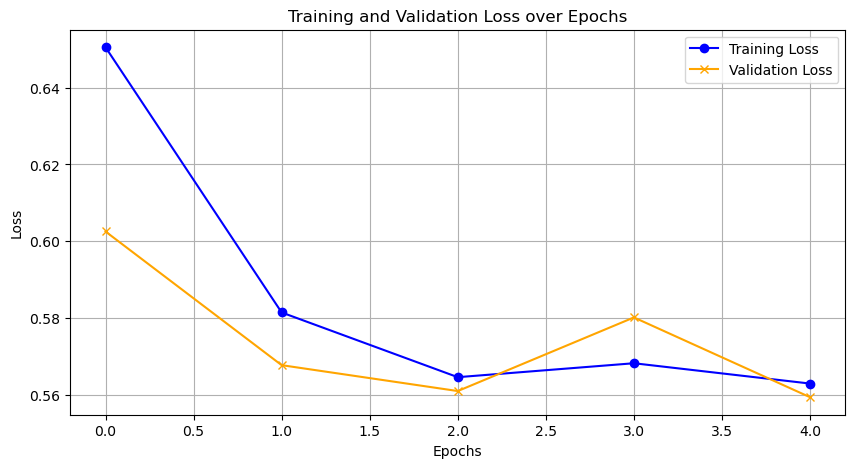

In [ ]:
plot_losses(train_losses, val_losses)

In [ ]:
def plot_confusion_matrix(conf_matrix, class_names=['Negative', 'Positive']):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(test_conf_matrix)

NameError: name 'test_conf_matrix' is not defined

In [ ]:
# Print sizes of each DataLoader (FOR CHECKING)
print_dataloader_sizes(train_dataloader, "Train")
print_dataloader_sizes(val_dataloader, "Validation")
print_dataloader_sizes(test_dataloader, "Test")

Train DataLoader: Total Samples = 927, Number of Batches = 29
Validation DataLoader: Total Samples = 199, Number of Batches = 13
Test DataLoader: Total Samples = 199, Number of Batches = 13


In [ ]:
train_df = pd.read_csv('results/train_predictions.csv')
train_df

FileNotFoundError: [Errno 2] No such file or directory: 'results/train_predictions.csv'

In [ ]:
eval_df = pd.read_csv('results/val_predictions.csv')
eval_df

In [ ]:
test_df = pd.read_csv('results/test_predictions.csv')
test_df